In [1]:
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
from itertools import cycle


import pyfiles.models as models
import pyfiles.lib as lib

In [3]:
tasks = 12
epochs = 100
learning_rate = 1e-3
batch_size = 64
on_colab = False
divide_tasks = True

category={0: 'boxingmoving', 
          1: 'boxingstill', 
          2: 'crawling', 
          3: 'running', 
          4: 'still', 
          5: 'walking', 
          6: 'walkinglow'}

cuda_available = False
if torch.cuda.is_available():
    cuda_available = True

dt = datetime.datetime.now()

### Get data

In [4]:
### Data: (# of subject, # of classes, # of data, width, height)
if divide_tasks:
    train_data = []
    test_data = []

    for task in range(1, tasks+1):
        if on_colab:
            data_path = 'drive/My Drive/projects/data/RADAR/Subject%d'%(task)
        else:
            data_path = './data/RADAR/Subject%d'%(task)

        train_data_per_task = []
        test_data_per_task = []
        for _, cat in category.items():
            # train data
            train_data_per_cat = []
            test_data_per_cat = []

            for i in range(1, 10):
                filename = 'Human_Spect_test%d_%s_0%d.png'%(task, cat, i)
                file_path = os.path.join(data_path, 'train', cat, filename)
                img = Image.open(file_path)
                img.load()
                img = np.array(img)
                train_data_per_cat.append(img)

            # test data
            for i in range(10, 13):
                filename = 'Human_Spect_test%d_%s_%d.png'%(task, cat, i)
                file_path = os.path.join(data_path, 'test', cat, filename)
                img = Image.open(file_path)
                img.load()
                img = np.array(img)
                test_data_per_cat.append(img)

            
            train_data_per_task.append(train_data_per_cat)
            test_data_per_task.append(test_data_per_cat)
            
        train_data.append(train_data_per_task)
        test_data.append(test_data_per_task)
        

    train_data = torch.Tensor(train_data)
    test_data = torch.Tensor(test_data)

    if cuda_available:
        train_data = train_data.cuda()
        test_data = test_data.cuda()

    print(train_data.shape)
    print(test_data.shape)

    train_labels = np.zeros((9, ))
    test_labels = np.zeros((3, ))

    for i in range(1, 7):
        train_labels = np.vstack((train_labels, np.zeros((9, )) + i))
        test_labels = np.vstack((test_labels, np.zeros((3, )) + i))

    train_labels = torch.Tensor(train_labels).type(torch.LongTensor)
    test_labels = torch.Tensor(test_labels).type(torch.LongTensor)

    if cuda_available:
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print(train_labels.shape)
    print(test_labels.shape)

torch.Size([12, 7, 9, 128, 128])
torch.Size([12, 7, 3, 128, 128])
torch.Size([7, 9])
torch.Size([7, 3])


In [4]:
if not divide_tasks:
    train_data = torch.empty((7, 108, 128, 128))
    test_data = torch.empty((7, 36, 128, 128))

    for task in range(1, tasks+1):
        if on_colab:
            data_path = 'drive/My Drive/projects/data/RADAR/Subject%d'%(task)
        else:
            data_path = './data/RADAR/Subject%d'%(task)

        for cat_i, cat in category.items():
            # train data
            for i in range(1, 10):
                filename = 'Human_Spect_test%d_%s_0%d.png'%(task, cat, i)
                file_path = os.path.join(data_path, 'train', cat, filename)
                img = Image.open(file_path)
                img.load()
                img = np.array(img)
                train_data[cat_i, (task - 1) * 9 + (i - 1)] = torch.Tensor(img)

            # test data
            for i in range(10, 13):
                filename = 'Human_Spect_test%d_%s_%d.png'%(task, cat, i)
                file_path = os.path.join(data_path, 'test', cat, filename)
                img = Image.open(file_path)
                img.load()
                img = np.array(img)
                test_data[cat_i, (task - 1) * 3 + (i - 10)] = torch.tensor(img)

    if cuda_available:
        train_data = train_data.cuda()
        test_data = test_data.cuda()

    print(train_data.shape)
    print(test_data.shape)
    
    train_labels = np.zeros((9*12, ))
    test_labels = np.zeros((3*12, ))

    for i in range(1, 7):
        train_labels = np.vstack((train_labels, np.zeros((9*12, )) + i))
        test_labels = np.vstack((test_labels, np.zeros((3*12, )) + i))

    train_labels = torch.Tensor(train_labels).type(torch.LongTensor)
    test_labels = torch.Tensor(test_labels).type(torch.LongTensor)

    if cuda_available:
        train_labels = train_labels.cuda()
        test_labels = test_labels.cuda()

    print(train_labels.shape)
    print(test_labels.shape)

torch.Size([7, 108, 128, 128])
torch.Size([7, 36, 128, 128])
torch.Size([7, 108])
torch.Size([7, 36])


In [5]:
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv_module = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, 5, 1), # 6 @ 124*124
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), # 6 @ 62*62
            torch.nn.Conv2d(6, 16, 7, 1), # 16 @ 56*56
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), # 16 @ 28*28
            # Conv 추가
            torch.nn.Conv2d(16, 16, 5, 1), # 16 @ 24*24
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2) # 16 @ 12*12
        )

        self.fc_module = torch.nn.Sequential(
            torch.nn.Linear(16*12*12, 128),
            torch.nn.ReLU(),
            #Linear 빼고
            #dropout 추가
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(128, 7)
        )

        if torch.cuda.is_available():
            self.conv_module = self.conv_module.cuda()
            self.fc_module = self.fc_module.cuda()

    def forward(self, input):
        x = self.conv_module(input)
        dim = x.shape[1] * x.shape[2] * x.shape[3]
        x = x.view(-1, dim)
        return self.fc_module(x)

### Training & Validation

In [6]:
print(train_data.shape)
print(train_labels.shape)

torch.Size([12, 7, 9, 128, 128])
torch.Size([7, 9])


In [7]:
net = NeuralNet()
if cuda_available:
    net = net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

logfile_name = "logfile_training_%d_%d_%d_%d_%d.txt" % (dt.year, dt.month, dt.day, dt.hour, dt.minute)
log_file = open(logfile_name, "w")

running_loss = 0
avg_acc = {}

net.train()
num_class, num_data, _, __ = train_data.shape
for i in range(5):
    for epoch in range(epochs):
    #     for key, _ in category.items():
        seed = torch.randperm(num_class * num_data)
        _train_data = train_data.view(-1, 1, 128, 128)[seed]
        _train_label = train_labels.view(-1)[seed]

        net.zero_grad()
        optimizer.zero_grad()

        outputs = net(_train_data)
        loss = criterion(outputs, _train_label)

        loss.backward()
        optimizer.step()

        running_loss += loss.data.item()

        if epoch % 50 == 49:
            msg = 'Epoch: %d, AVG. loss: %.3f\n'% (epoch + 1, running_loss)
            print(msg)
            log_file.write(msg)
            running_loss = 0

    total = 0
    correct = 0
    net.eval()
    for key, _ in category.items():
        _test_data = test_data[key].view(3*12, 1, 128, 128)
        output = net(_test_data)
        _, predicted = torch.max(output.data, dim=1)
        total += test_labels[key].shape[0]
        correct += (predicted == test_labels[key]).sum()

    acc = correct.cpu().numpy()*100/total
    msg = 'Average accuracy %d %%\n' % (acc)
    print(msg)
    log_file.write(msg)
log_file.close()

ValueError: too many values to unpack (expected 4)

In [16]:
hidden_layer_num = 1000
epochs = 200
ewc_acc = {}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = models.ConvolutionNetwork().to(device)
lib.init_params(net)
crit = torch.nn.CrossEntropyLoss()

optim = torch.optim.Adam(net.parameters(), lr=0.001)

for task in range(tasks):
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        x = train_data[task].view(-1, 1, 128, 128)
#         x = train_data[task].view(-1, 128*128)
        seed = torch.randperm(x.shape[0])
        x = x[seed]
        y = train_labels.view(-1)[seed]
#             print(x.shape, y.shape)

        optim.zero_grad()
        net.zero_grad()
        outputs = net(x)
        loss = crit(outputs, y)
        loss.backward()
        optim.step()
        running_loss += loss.item()

        if epoch % 50 == 49:
            print("[Epoch %d/%d] Loss: %.3f"%(epoch+1, epochs, running_loss))

    ## Evaluation
    each_task_acc = torch.zeros((task+1, )).to(device)

    net.eval()
    for t in range(task+1):
        total = 0.0
        correct = 0.0
        x = test_data[t].view(-1, 1, 128, 128)
#         x = test_data[t].view(-1, 128 * 128)
        y = test_labels.view(-1)

        outputs = net(x)
        _, predicted = torch.max(outputs, dim=1)
        total += x.shape[0]

        correct += (predicted == y).sum()

        each_task_acc[t] = (correct / total) * 100

    acc_mean = torch.mean(each_task_acc)
    print('[Task %d] avg accuracy: %.3f%%'%(task+1, acc_mean))
    print(each_task_acc)

    ewc_acc[t] = acc_mean


[Epoch 50/200] Loss: 0.302
[Epoch 100/200] Loss: 0.028
[Epoch 150/200] Loss: 0.013
[Epoch 200/200] Loss: 0.013
[Task 1] avg accuracy: 85.714%
tensor([85.7143], device='cuda:0')
[Epoch 50/200] Loss: 0.010
[Epoch 100/200] Loss: 0.002
[Epoch 150/200] Loss: 0.000
[Epoch 200/200] Loss: 0.001
[Task 2] avg accuracy: 66.667%
tensor([66.6667, 66.6667], device='cuda:0')
[Epoch 50/200] Loss: 0.054
[Epoch 100/200] Loss: 0.020
[Epoch 150/200] Loss: 0.003
[Epoch 200/200] Loss: 0.003
[Task 3] avg accuracy: 77.778%
tensor([ 57.1429,  76.1905, 100.0000], device='cuda:0')
[Epoch 50/200] Loss: 0.005
[Epoch 100/200] Loss: 0.004
[Epoch 150/200] Loss: 0.002
[Epoch 200/200] Loss: 0.000
[Task 4] avg accuracy: 79.762%
tensor([ 52.3810,  71.4286,  95.2381, 100.0000], device='cuda:0')
[Epoch 50/200] Loss: 0.057
[Epoch 100/200] Loss: 0.003
[Epoch 150/200] Loss: 0.005
[Epoch 200/200] Loss: 0.004
[Task 5] avg accuracy: 82.857%
tensor([76.1905, 85.7143, 71.4286, 85.7143, 95.2381], device='cuda:0')
[Epoch 50/200] Los

#### plain data

In [2]:
acc_dict={'plain':{0: 85.7143, 1: 66.6667, 2: 77.7778, 3: 79.7619, 4: 82.8571, 5: 69.0476, 6: 80.2721, 7: 79.1667, 8: 62.4339, 9: 66.1905, 10: 70.9957, 11: 64.6825}, 'ewc':{0: 76.1905, 1: 73.8095, 2: 76.1905, 3: 82.1429, 4: 84.7619, 5: 80.9524, 6: 78.2313, 7: 82.7381, 8: 72.4868, 9: 84.2857, 10: 83.5498, 11: 82.5397}, 'dgr':{0: 86.1905, 1: 78.8095, 2: 68.8095, 3: 77.1905, 4: 82.7619, 5: 77.9524, 6: 65.2313, 7: 73.7212, 8: 73.1973, 9: 61.2857, 10: 80.7482, 11: 83.6385}}

#### dgr & modified

In [5]:
acc_dict={'dgr': {0: 97.92, 1: 96.215, 2: 93.52333333333333, 3: 89.8775, 4: 85.39399999999999}, 'M = 300':{0: 94.38, 1: 93.38, 2: 89.82666667, 3: 84.6075, 4: 80.94}, 'M = 1000': {0: 94.81999969482422, 1: 94.16999816894531, 2: 92.21333821614583, 3: 88.62750244140625, 4: 86.18200073242187}}

### Plot

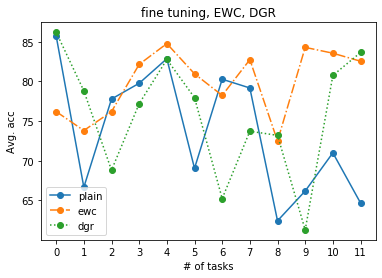

In [4]:
plt.xlabel("# of tasks")
plt.ylabel("Avg. acc")
plt.xticks([i for i in range(0, 12)])
plt.title("fine tuning, EWC, DGR")

linestyle_cycler = cycle(['-','-.',':'])
for coef, acc in acc_dict.items():
    x, y = list(acc.keys()), list(acc.values())
    plt.plot(x, y, next(linestyle_cycler), label=str(coef), marker='o')

plt.legend(loc=3)
plt.savefig('radar_plain&ewc.png', dpi=400)
plt.show()